In [1]:
install.packages('dplyr')
install.packages('ggplot2')
install.packages('lme4')
install.packages('ggeffects')
install.packages('tidyr')
install.packages('broom')
install.packages('MuMIn')


The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//RtmplshLGh/downloaded_packages


In [2]:
library(dplyr)
library(ggplot2)
library(lme4)
library(ggeffects)
library(tidyr)
library(broom)
library(MuMIn)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Registered S3 methods overwritten by 'MuMIn':
  method        from 
  nobs.multinom broom
  nobs.fitdistr broom



In [3]:
vf = read.csv('von_frey_dataset.csv')

# Applying Linear Models to find the one with the best fit 

In [4]:
# standardizing day number for better convergence of the lme models 
vf$DayNumber_z = scale(vf$DayNumber)

In [5]:
# creating multiple models 
m1 = lmer (Force ~ DayNumber_z + (DayNumber_z| ID), data = vf)
m2 = lmer (Force ~ DayNumber_z * Trial + (DayNumber_z |ID), data = vf)

In [6]:
#comparing nested models to find one that fits the data best 
anova(m1,m2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1,6,19479.51,19514.10,-9733.755,19467.51,NA,NA,NA
m2,8,19199.42,19245.55,-9591.711,19183.42,284.0891,2,2.045683e-62


Observations- 
- m2 seems to give the best fit of the two models on the basis of its extremely significant p-value (<0.001) and much lower AIC value. 

In [9]:
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z * Trial + (DayNumber_z | ID)
   Data: vf

REML criterion at convergence: 19179

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6076 -0.7496 -0.0673  0.6920  3.8242 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  25.846   5.084        
          DayNumber_z   5.898   2.428   -0.74
 Residual             194.662  13.952        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
                   Estimate Std. Error t value
(Intercept)         33.4750     1.3000  25.750
DayNumber_z         -1.7795     0.7343  -2.423
TrialI             -10.0487     0.5904 -17.020
DayNumber_z:TrialI  -1.8118     0.5802  -3.123

Correlation of Fixed Effects:
            (Intr) DyNmb_ TrialI
DayNumber_z -0.497              
TrialI      -0.247  0.011       
DyNmbr_z:TI  0.004 -0.412 -0.019

## Linear model-predicted withdrawal force trajectories 

In [10]:
# extract mean and SD to backtransform standardized day number to actual day number 
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd = sd(vf$DayNumber, na.rm = FALSE)

In [11]:
# get model predictions for both sides 
pred = ggpredict(m2, terms = c('DayNumber_z', 'Trial'))

In [12]:
# convert standardized day to day 
pred$DayNumber = pred$x * day_sd + day_mean

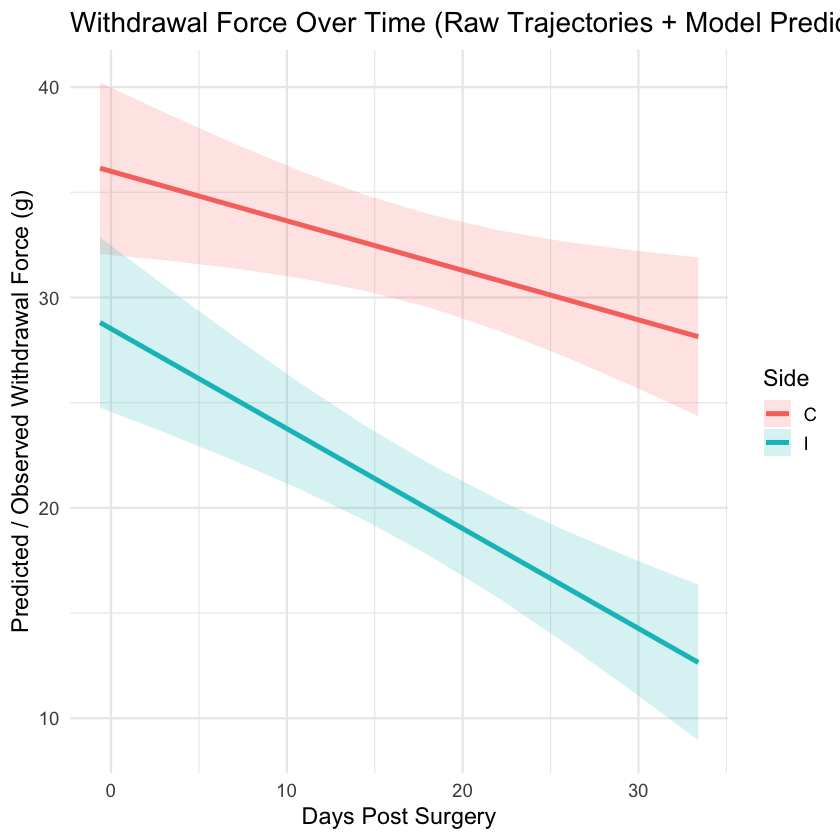

In [13]:
#population-level prediction 
ggplot() +
  # Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(
    title = "Withdrawal Force Over Time (Raw Trajectories + Model Predictions)",
    x = "Days Post Surgery",
    y = "Predicted / Observed Withdrawal Force (g)",
    color = "Side",
    fill  = "Side"
  ) +
  theme_minimal(base_size = 14)

In [14]:
#individual trajectories predicted by the model 
ind_preds <- vf %>%
  distinct(ID, Trial) %>%                 # one row per rat per side
  group_by(ID, Trial) %>%
  do({
    DayNumber_z_seq <- seq(min(vf$DayNumber_z, na.rm = TRUE),
                           max(vf$DayNumber_z, na.rm = TRUE),
                           length.out = 100)
    data.frame(
      ID = .$ID[1],
      Trial = .$Trial[1],
      DayNumber_z = DayNumber_z_seq,
      DayNumber   = DayNumber_z_seq * day_sd + day_mean,
      pred = predict(
        m2,
        newdata = data.frame(
          DayNumber_z = DayNumber_z_seq,
          ID = .$ID[1],
          Trial = .$Trial[1]              
        )
        
      )
    )
  }) %>%
  ungroup()

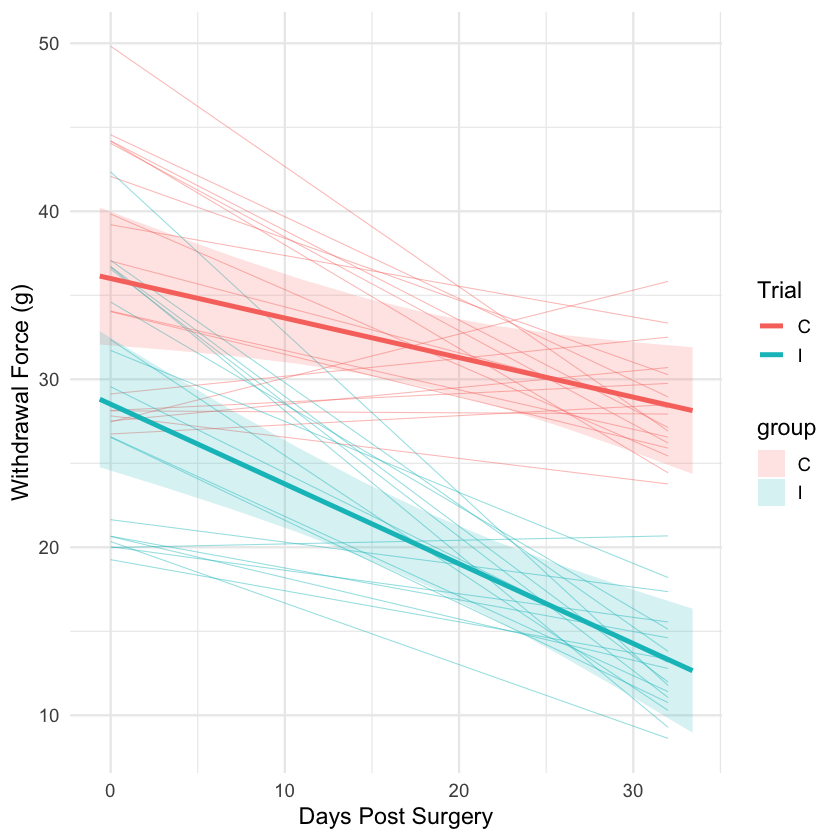

In [15]:
# population-level prediction overlayed on individual trajectory prediction 
ggplot() +
  geom_line(data = ind_preds,
            aes(x = DayNumber, y = pred,
                group = interaction(ID, Trial), color = Trial),
            alpha = 0.45, linewidth = 0.3) +
# Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(x = "Days Post Surgery", y = "Withdrawal Force (g)")+
  theme_minimal(base_size = 14)

In [16]:
r.squaredGLMM(m2)

R2m,R2c
0.1251467,0.247799


- R2m(marginal r squared) ~12.5 %variance explained by fixed effects 
- R2c(conditional r squared) ~24.8 %variance explained by fixed + random effects 

In [17]:
m3 = lmer(
  Force ~ DayNumber_z * Stage + Trial + (DayNumber_z | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient



In [18]:
summary(m3)
r.squaredGLMM(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z * Stage + Trial + (DayNumber_z | ID)
   Data: vf

REML criterion at convergence: 19106.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7603 -0.7422 -0.0680  0.6802  3.3902 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  26.155   5.114        
          DayNumber_z   5.619   2.370   -0.80
 Residual             188.934  13.745        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  31.5833     1.3177  23.968
DayNumber_z  -0.5198     0.6915  -0.752
StagePRE      9.8617     1.0834   9.103
TrialI       -9.8196     0.5823 -16.865

Correlation of Fixed Effects:
            (Intr) DyNmb_ StgPRE
DayNumber_z -0.623              
StagePRE    -0.162  0.343       
TrialI      -0.247  0.022  0.051
fit warnings:
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

R2m,R2c
0.1515269,0.2736662


- R2m(marginal r squared) ~15% variance explained by fixed effects
- R2c(conditional r squared) ~27% variance explained by fixed + random effects

## Applying non-linear models to check for better fit

In [19]:
# use a non-linear term 
vf$DayNumber_z2 <- vf$DayNumber_z^2

In [20]:
m4 = lmer(
  Force ~ DayNumber_z + DayNumber_z2 + Stage + Trial +
          DayNumber_z:Stage + DayNumber_z2:Stage +
          (DayNumber_z + Trial | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients



In [21]:
summary(m4)
r.squaredGLMM(m4)

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ DayNumber_z + DayNumber_z2 + Stage + Trial + DayNumber_z:Stage +  
    DayNumber_z2:Stage + (DayNumber_z + Trial | ID)
   Data: vf

REML criterion at convergence: 19019.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1850 -0.7244 -0.0478  0.6974  3.7708 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 ID       (Intercept)  29.952   5.473              
          DayNumber_z   6.546   2.558   -0.74      
          TrialI       34.353   5.861   -0.45  0.07
 Residual             179.734  13.407              
Number of obs: 2358, groups:  ID, 18

Fixed effects:
             Estimate Std. Error t value
(Intercept)   30.6574     1.4258  21.502
DayNumber_z   -1.1846     0.7636  -1.551
DayNumber_z2   0.8550     0.3595   2.378
StagePRE       7.7852     1.3204   5.896
TrialI        -8.7661     1.5513  -5.651

Correlation of Fixed Effects:
            (Intr) DyNmb_ DyNm_2 StgPRE
DayNumber_z -0.497 

R2m,R2c
0.1392014,0.2946344


In [22]:
m4 = lmer(
  Force ~ poly(DayNumber_z, 2, raw=TRUE) * Stage + Trial + (DayNumber_z | ID),
  data = vf)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients



In [23]:
summary(m4)
r.squaredGLMM(m4)

Linear mixed model fit by REML ['lmerMod']
Formula: 
Force ~ poly(DayNumber_z, 2, raw = TRUE) * Stage + Trial + (DayNumber_z |  
    ID)
   Data: vf

REML criterion at convergence: 19099.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7664 -0.7409 -0.0685  0.6846  3.3910 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  26.598   5.157        
          DayNumber_z   6.563   2.562   -0.78
 Residual             188.239  13.720        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
                                  Estimate Std. Error t value
(Intercept)                        30.8246     1.3575  22.707
poly(DayNumber_z, 2, raw = TRUE)1  -1.1869     0.7715  -1.538
poly(DayNumber_z, 2, raw = TRUE)2   0.9945     0.3669   2.711
StagePRE                            7.6843     1.3489   5.697
TrialI                             -9.7114     0.5825 -16.672

Correlation of Fixed Effects:
                 (Intr) p(DN_,2,r=TRUE)1 p(DN_,2,r=T

R2m,R2c
0.1541752,0.2808528


In [24]:
#comparing two best model
anova(m2,m4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m2,8,19199.42,19245.55,-9591.711,19183.42,NA,NA,NA
m4,9,19122.64,19174.53,-9552.318,19104.64,78.78552,1,6.923268e-19


The non linear model seems to have an improved R2m and R2c value as compared to the linear model. The likelihood ratio test showed a highly significant p-value for the non linear model (p<<0.001). Given these improvements and interpretability, we did not pursue further models. 